# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Analyse Strategy Performance

In this notebook, you will learn to analyse the performance of the strategy using various performance metrics.

## Create a long short strategy

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

 # The data is stored in the directory 'data'
path = '../data_modules/'

# Read daily Apple stock data
stock_data = pd.read_csv(path + 'daily_apple_data.csv', index_col=0)

# Set index to datetime
stock_data.index = pd.to_datetime(stock_data.index)

# Calculate parabolic SAR
stock_data['SAR'] = ta.SAR(stock_data['High'].values, stock_data['Low'].values,
                           acceleration=0.02, maximum=0.2)

# Calculate stochastic oscillator
stock_data['slowk'], stock_data['slowd'] = ta.STOCH(stock_data['High'].values, stock_data['Low'].values,
                                                    stock_data['Close'].values, fastk_period=5, slowk_period=3, slowd_period=3)


stock_data['fastk'], stock_data['fastd'] = ta.STOCHF(stock_data['High'].values, stock_data['Low'].values,
                                                     stock_data['Close'].values, fastk_period=5, fastd_period=3)

# Column to store trading signals
stock_data['signal'] = np.nan


# Buy signal
stock_data.loc[(stock_data['SAR'] < stock_data['Close']) & (stock_data['fastd'] > stock_data['slowd'])
               & (stock_data['fastk'] > stock_data['slowk']), 'signal'] = 1

# Sell signal
stock_data.loc[(stock_data['SAR'] > stock_data['Close']) & (stock_data['fastd'] < stock_data['slowd'])
               & (stock_data['fastk'] < stock_data['slowk']), 'signal'] = -1

# Fill the missing values with last valid observation
stock_data = stock_data.fillna(method = 'ffill')

# Calculate stock returns
stock_data['stock_returns'] = stock_data['Close'].pct_change()

# Calculate strategy returns
stock_data['strategy_returns'] = (
    stock_data['stock_returns'] * stock_data['signal'].shift(1))

# Drop NaN values
stock_data = stock_data.dropna()

# Calculate total cost
transaction_cost = 0.001
slippage_cost = 0.0022
total_cost = transaction_cost + slippage_cost

# Calculate the trading cost when you square off the position
trading_cost = (total_cost * np.abs(stock_data.signal -
                                    stock_data.signal.shift(1)))

# Calculate net strategy returns
stock_data['strategy_returns_minus_cost'] = stock_data['strategy_returns'] - trading_cost

# Calculate cumulative strategy returns
cum_strategy_returns = ((stock_data['strategy_returns_minus_cost'] + 1).cumprod())

<a id='strategy_performance'></a>
## Analyse Strategy Performance

### Plot Cumulative Strategy Returns

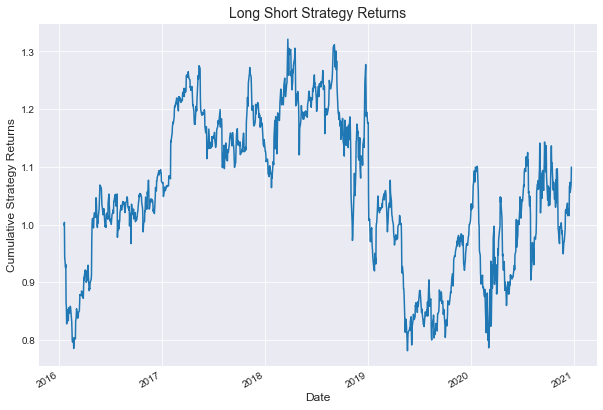

In [2]:
def plot_strategy_returns(cumulative_strategy_returns, title):

    # Plot cumulative strategy returns
    plt.figure(figsize=(10, 7))
    cumulative_strategy_returns.plot()

    # Set title of the figure
    plt.title(title, fontsize=14)

    # Set labels for x-axis and y-axis
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Strategy Returns', fontsize=12)

    plt.show()


plot_strategy_returns(cum_strategy_returns, 'Long Short Strategy Returns')

### Calculate total/absolute returns

In [3]:
total_returns = (cum_strategy_returns.iloc[-1]-1)*100

print('The total returns of strategy is %.2f' % total_returns + '%')

The total returns of strategy is 9.95%


### Calculate annualised returns

The annual returns are returns that investment has earned over one year.

In [4]:
# Total number of trading days
days = len(cum_strategy_returns)

# Calculate compounded annual growth rate
cagr = (cum_strategy_returns.iloc[-1]**(252/days)-1)*100
print('The CAGR of strategy is %.2f' % cagr + '%')

The CAGR of strategy is 1.94%


### Sharpe ratio
The Sharpe ratio is the excess returns per unit of volatility. Excess return is total returns minus the risk-free rate of return. Generally, risk-free return is the return on the risk-free assets such as government bonds. 

In [5]:
# Assume an average annual risk-free rate is 1%
risk_free_rate = 0.04/252

sharpe = np.sqrt(252)*(np.mean(stock_data.strategy_returns) -
                       (risk_free_rate))/np.std(stock_data.strategy_returns)
print("The Sharpe ratio of strategy is %.2f" % sharpe)

The Sharpe ratio of strategy is 0.49


### Maximum drawdown
Maximum drawdown measures the peak-to-trough decline in the value of the portfolio and is quoted as the percentage of the peak value.

In [6]:
def calc_drawdown(cum_rets):

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1

    # Calculate maximum drawdown
    max_dd = drawdown.min()*100

    return drawdown, max_dd


drawdown, max_dd = calc_drawdown(cum_strategy_returns)

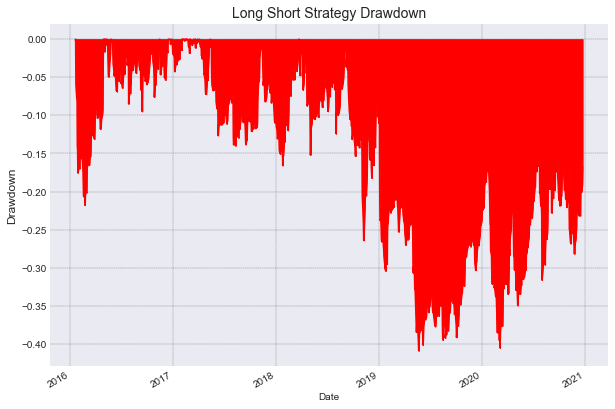

The maximum drawdown of strategy is -40.88%


In [7]:
def plot_drawdown(drawdown, title):

    # Plot drawdown
    plt.figure(figsize=(10, 7))
    drawdown.plot(color='r')
    plt.ylabel('Drawdown', fontsize = 12)
    plt.title(title, fontsize=14)
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()


plot_drawdown(drawdown,'Long Short Strategy Drawdown')

print("The maximum drawdown of strategy is %.2f" % max_dd + '%')

---

## Create a long only strategy

In [8]:
# Column to store new trading signals
stock_data['new_signal'] = np.nan


# Buy signal
stock_data.loc[(stock_data['SAR'] < stock_data['Close']) & (stock_data['fastd'] > stock_data['slowd'])
               & (stock_data['fastk'] > stock_data['slowk']), 'new_signal'] = 1

# Exit signal
stock_data.loc[(stock_data['SAR'] > stock_data['Close']) & (stock_data['fastd'] < stock_data['slowd'])
               & (stock_data['fastk'] < stock_data['slowk']), 'new_signal'] = 0

# Fill the missing values with last valid observation
stock_data = stock_data.fillna(method = 'ffill')

# Calculate strategy returns
stock_data['new_strategy_returns'] = (
    stock_data['stock_returns'] * stock_data['new_signal'].shift(1))

# Calculate net strategy returns
stock_data['new_strategy_returns_minus_cost'] = stock_data['new_strategy_returns'] - trading_cost

# Drop NaN values
stock_data = stock_data.dropna()

# Calculate and plot cumulative strategy returns
new_cum_strategy_returns = (stock_data['new_strategy_returns_minus_cost']+1).cumprod()

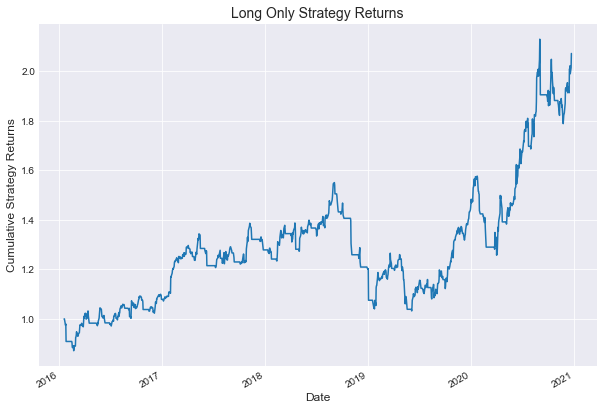

In [9]:
# Plot cumulative strategy returns
plot_strategy_returns(new_cum_strategy_returns, 'Long Only Strategy Returns')

In [10]:
# Calculate total/absolute returns
new_total_returns = (new_cum_strategy_returns.iloc[-1]-1)*100

print('The total returns of strategy is %.2f' % new_total_returns + '%')

The total returns of strategy is 107.04%


In [11]:
# Calculate compounded annual growth rate
new_cagr = (new_cum_strategy_returns.iloc[-1]**(252/days)-1)*100
print('The CAGR of strategy is %.2f' % new_cagr + '%')

The CAGR of strategy is 15.90%


In [12]:
# Calculate Sharpe ratio
new_sharpe = np.sqrt(252)*(np.mean(stock_data.new_strategy_returns) -
                           (risk_free_rate))/np.std(stock_data.new_strategy_returns)
print("The Sharpe ratio of strategy %.2f" % new_sharpe)

The Sharpe ratio of strategy 1.23


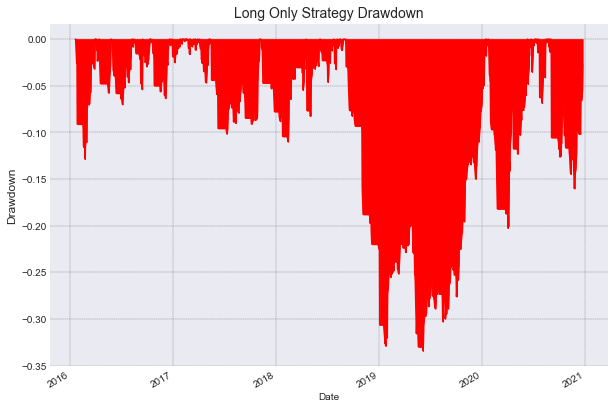

The maximum drawdown of strategy is -33.40%


In [13]:
# Calculate drawdown
new_drawdown, new_max_dd = calc_drawdown(new_cum_strategy_returns)
plot_drawdown(new_drawdown, 'Long Only Strategy Drawdown')
print("The maximum drawdown of strategy is %.2f" % new_max_dd + '%')

## Performance summary

In [14]:
# Import tabulate
from tabulate import tabulate

stats = tabulate(
        [
            ['Strategy Returns', total_returns, new_total_returns],
            ['Sharpe', sharpe, new_sharpe],
            ['CAGR', cagr, new_cagr],
            ['Maximum Drawdown', drawdown.min()*100, new_drawdown.min()*100]
    
        ],
        headers=['Stats Name','Long Short Strategy', 'Long Only Strategy'], tablefmt='orgtbl')

print(stats)

| Stats Name       |   Long Short Strategy |   Long Only Strategy |
|------------------+-----------------------+----------------------|
| Strategy Returns |              9.95208  |            107.037   |
| Sharpe           |              0.487167 |              1.22522 |
| CAGR             |              1.94206  |             15.8975  |
| Maximum Drawdown |            -40.8794   |            -33.3998  |
